# Clasificacion Binaria de Tumores Cerebrales

## Los tumores cerebrales son considerados como una de las enfermedades mas agresivas. La tasa de supervivencia a 5 años para las personas con un tumor canceroso en el cerebro es de 35 porciento. 

## La mejor manera para detectar tumores cerebrales es por una Imagen de Resonancia Magnetica, Estas imagenes deben ser examinadas por un radiologo y se requiere de un Neurocirujano profesional para el analisis de la resonancia.

## Mi proyecto puede ayudar en comunidades donde falten especialista y no se tenga un buen conocimiento sobre tumores cerebrales, Un sistema de prediccion en donde se pueda consultar desde la nube ayudaria en estos casos.

# Parte 1 : Procesamiento de los datos, en este caso las imagenes sacadas de Kaggle.

In [1]:
# Importaremos todas las librerias necesarias
import os 
import glob
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, MaxPooling2D
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import cv2



In [2]:
# Crearemmos una funcion para guardar en una lista las imagenes de cada carpeta
def import_data(path):
    lista = []
    # glob sirve para saber todas las path que hay en la carpeta especificada
    for filename in glob.glob(path):
        lista.append(filename)
    return lista

In [3]:
# Cargamos el path de las carpetas que ocuparemos
no_data_path = "./archive/no/*.jpg"
yes_data_path = "./archive/yes/*.jpg"
pred_data_path = "./archive/pred/*.jpg"
# importamos los datos
train_no = import_data(no_data_path)
train_yes = import_data(yes_data_path)
test = import_data(pred_data_path)
# Creamos los dataset de train yes y train no con columnas de imagen y su etiqueta
df_train_no = pd.DataFrame({'image':train_no, 'label':'No'})
df_train_yes = pd.DataFrame({'image':train_yes, 'label':'Yes'})
# igual creamos un dataset para el test con solo la columna de imagen
df_test = pd.DataFrame({'image':test})

train_data = pd.concat([df_train_no, df_train_yes])
train_data

,image,label
0,./archive/no/no1157.jpg,No
1,./archive/no/no132.jpg,No
2,./archive/no/no654.jpg,No
3,./archive/no/no640.jpg,No
4,./archive/no/no898.jpg,No
...,...,...
1495,./archive/yes/y364.jpg,Yes
1496,./archive/yes/y1428.jpg,Yes
1497,./archive/yes/y402.jpg,Yes
1498,./archive/yes/y416.jpg,Yes


In [4]:
# Dividimos los dataos en datos de entrenamiento y de testing
train_data,test_data = train_test_split(
    train_data,
    train_size=0.9,
    shuffle=True,
    random_state=42
)

In [5]:
# Imprimimos el numero de columnas y de filas del dataset de train para corroborar que todo este bien 
print(train_data.shape)

(2700, 2)


In [6]:
print(train_data.head())

                        image label
433    ./archive/no/no757.jpg    No
1151   ./archive/no/no846.jpg    No
73    ./archive/no/no1368.jpg    No
36     ./archive/yes/y962.jpg   Yes
1209   ./archive/yes/y942.jpg   Yes


In [7]:
# Imprimimos el numero de columnas y de filas del dataset de validacion para corroborar que todo este bien 
print(test_data.shape)

(300, 2)


In [8]:
# Usaremos ImageDataGenerator para normalizar los datos y que puedan entrar ala red neuronal
datagen = ImageDataGenerator(rescale=1.0/255,
                            validation_split=0.1)
batch_size = 20 # Definimos el tamano del batch
IMG_SIZE = 200 # Definimos cuanto queremos que cambiar el lado de la imagen
size = (IMG_SIZE,IMG_SIZE) # Definimos un arreglo cuadrado de la imagen con la longitud definidia anteriormente

# En las siguiente variables declaramos el dataset que ingresara ala red neuronal

train_set = datagen.flow_from_dataframe(dataframe=train_data, 
                                        #directory = './archive/*.jpg',
                                        x_col = 'image',
                                        y_col = 'label',
                                        color_mode="grayscale",
                                        class_mode="categorical",
                                        subset="training",
                                        batch_size=batch_size,
                                        target_size=size,
                                        interpolation = 'bilinear',
                                        shuffle = True)
val_set = datagen.flow_from_dataframe(dataframe=train_data,
                                      #directory = './archive/*.jpg',
                                      x_col = 'image',
                                      y_col = 'label',
                                      color_mode="grayscale",
                                      class_mode="categorical",
                                      subset="validation",
                                      batch_size=batch_size,
                                      target_size=size,
                                      interpolation = 'bilinear',
                                      shuffle = True)

Found 2430 validated image filenames belonging to 2 classes.
Found 270 validated image filenames belonging to 2 classes.


In [9]:
test_Set = datagen.flow_from_dataframe(dataframe=test_data,
                                              x_col="image",
                                              y_col="label",
                                              color_mode="grayscale",
                                              class_mode="categorical",
                                              batch_size=batch_size,
                                              target_size=size)

Found 300 validated image filenames belonging to 2 classes.


In [10]:
# Declaramos nuestro callback para que al 95 porciento de precicion se detenga y no suframos de 
# overfitting
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>=95):
            print("\n Haz alcanzado el 97 % de precicion.")
            self.model.stop_traning = True
es = EarlyStopping(monitor='val_loss', mode='min',
                       patience=2,
                       restore_best_weights=True,
                       verbose=1)
checkpoint_cb = ModelCheckpoint("Brain_model_best.h5",
                                    save_best_only=True)
    
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                            factor = 0.2,
                                  patience = 3,
                                  min_lr = 1e-5,
                                  mode = 'min',
                                  verbose=1)

In [11]:
Model = Sequential() #Declaramos la red Neuronal

Model.add(Conv2D(32,(5,5),activation="relu",input_shape=(200,200,1))) # Usamos Conv2D por que son imagenes
Model.add(MaxPool2D((2,2))) # Usamos Maxpool2D para probar filtros y ver que se resalta mas
Model.add(Dropout(0.2)) # Este metodo desactiva alguinas neuronas para reducir el overfitting 
#
Model.add(Conv2D(64,(3,3),activation="relu"))
Model.add(MaxPool2D((2,2)))
Model.add(Dropout(0.2))
#
Model.add(Conv2D(128,(3,3),activation="relu"))
Model.add(MaxPool2D((2,2)))
Model.add(Dropout(0.2))
#
Model.add(Conv2D(256,(3,3),activation="relu"))
Model.add(MaxPool2D((2,2)))
Model.add(Dropout(0.2))
#
Model.add(Flatten()) # convertimos la imagen a una sola dimension
Model.add(Dropout(0.5))
Model.add(Dense(512,activation="relu"))
Model.add(Dense(2,activation="softmax")) # Ocupamos solo una neuronal para decirnos si hay o no hay cancer

Metal device set to: Apple M1


2023-04-04 16:00:50.266430: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-04 16:00:50.266716: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
# Compilamos el modelo para que nos de la "accuracy"
Model.compile(optimizer=RMSprop(lr=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])


/Users/sebastian_zarraga/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
#callback = MyCallback() # Declaramos nuestro callback para despues usarlo
history = Model.fit(train_set,# Dataset de entrenamiento
                    validation_data=val_set, # Dataset de validacion
                    epochs=25, # Epocas a utilizar
                    steps_per_epoch=120, # Pasos que daremos por epoca
                    callbacks=[es, reduce_lr]
                   )


Epoch 1/25


2023-04-04 16:00:50.606056: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-04 16:00:50.863563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - ETA: 0s - loss: 0.6522 - accuracy: 0.6996

2023-04-04 16:01:07.414750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 17s 139ms/step - loss: 0.6522 - accuracy: 0.6996 - val_loss: 0.5448 - val_accuracy: 0.7704 - lr: 0.0010
Epoch 2/25
120/120 [==============================] - 16s 134ms/step - loss: 0.4138 - accuracy: 0.8305 - val_loss: 0.4537 - val_accuracy: 0.7889 - lr: 0.0010
Epoch 3/25
120/120 [==============================] - 17s 140ms/step - loss: 0.3278 - accuracy: 0.8644 - val_loss: 0.3231 - val_accuracy: 0.8815 - lr: 0.0010
Epoch 4/25
120/120 [==============================] - 16s 135ms/step - loss: 0.2574 - accuracy: 0.8929 - val_loss: 0.2057 - val_accuracy: 0.9370 - lr: 0.0010
Epoch 5/25
120/120 [==============================] - 16s 136ms/step - loss: 0.2032 - accuracy: 0.9222 - val_loss: 0.2774 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 6/25
120/120 [==============================] - 16s 136ms/step - loss: 0.1705 - accuracy: 0.9431 - val_loss: 0.1591 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 7/25
120/120 [==============================] - 16s 137ms

In [14]:
# Ocupe una funcion que programe en un curso para poder el rendimiento del modelo
def plt_loss_acc(history):
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')
    
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, label='Traning Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title("Traning and validation Accuracy")
    
    plt.figure()
    
    plt.plot(epochs, loss, label = "Traning loss")
    plt.plot(epochs, val_loss, label = "Validation loss")
    plt.title("Traning and validation Loss")
    
    plt.show()

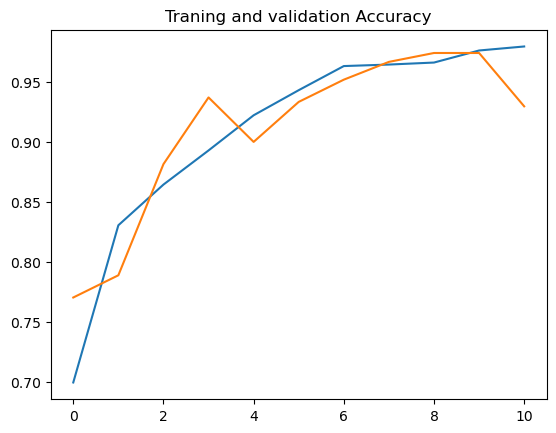

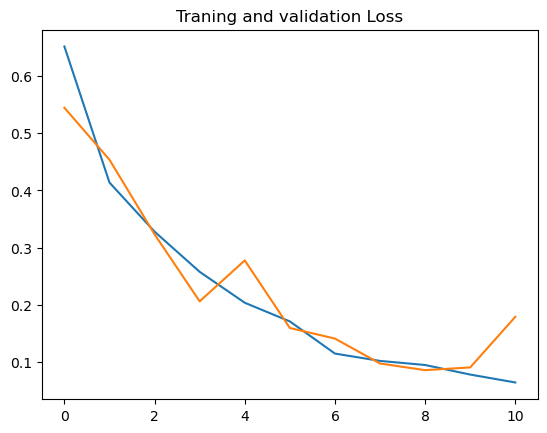

In [15]:
plt_loss_acc(history)

In [16]:
#Model.save("modelCancerBrain.h5") # Guardamos el modelo en un archivo con extension h5

In [17]:
Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 196, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 98, 98, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 48, 48, 64)        0

In [18]:
Model_Test_Prediction = Model.predict(test_Set)

 3/15 [=====>........................] - ETA: 0s

2023-04-04 16:03:55.578419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 38ms/step


In [19]:
Model_Test_Prediction = Model_Test_Prediction.argmax(axis=-1)

In [20]:
print(Model_Test_Prediction)


[1 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 1
 1 0 0 0 1 1 0 0 0 1 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 0
 0 0 0 1 1 0 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1
 1 1 1 1 0 0 0 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 0
 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 0 0 1 0
 1 0 1 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0
 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0
 1 0 1 0]


In [25]:
Last_Prediction = []
[Last_Prediction.append('SANO') if i == 1 else Last_Prediction.append('TUMOR') for i in Model_Test_Prediction]
print(Last_Prediction)

['SANO', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'SANO', 'TUMOR', 'SANO', 'SANO', 'SANO', 'SANO', 'TUMOR', 'SANO', 'TUMOR', 'SANO', 'SANO', 'SANO', 'TUMOR', 'SANO', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'SANO', 'SANO', 'TUMOR', 'SANO', 'TUMOR', 'TUMOR', 'SANO', 'SANO', 'TUMOR', 'TUMOR', 'SANO', 'SANO', 'TUMOR', 'TUMOR', 'TUMOR', 'SANO', 'SANO', 'TUMOR', 'TUMOR', 'TUMOR', 'SANO', 'SANO', 'SANO', 'TUMOR', 'SANO', 'TUMOR', 'SANO', 'SANO', 'TUMOR', 'SANO', 'SANO', 'TUMOR', 'SANO', 'SANO', 'TUMOR', 'SANO', 'SANO', 'SANO', 'SANO', 'TUMOR', 'TUMOR', 'SANO', 'SANO', 'SANO', 'TUMOR', 'SANO', 'SANO', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'SANO', 'SANO', 'TUMOR', 'SANO', 'SANO', 'SANO', 'TUMOR', 'TUMOR', 'SANO', 'TUMOR', 'SANO', 'TUMOR', 'SANO', 'SANO', 'SANO', 'TUMOR', 'SANO', 'SANO', 'TUMOR', 'TUMOR', 'TUMOR', 'SANO', 'SANO', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'SANO', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'SANO', 'SANO', 'SANO', 'SANO', 'SANO', 'SANO', 'TUMOR', 'TUMOR', 'TUMOR

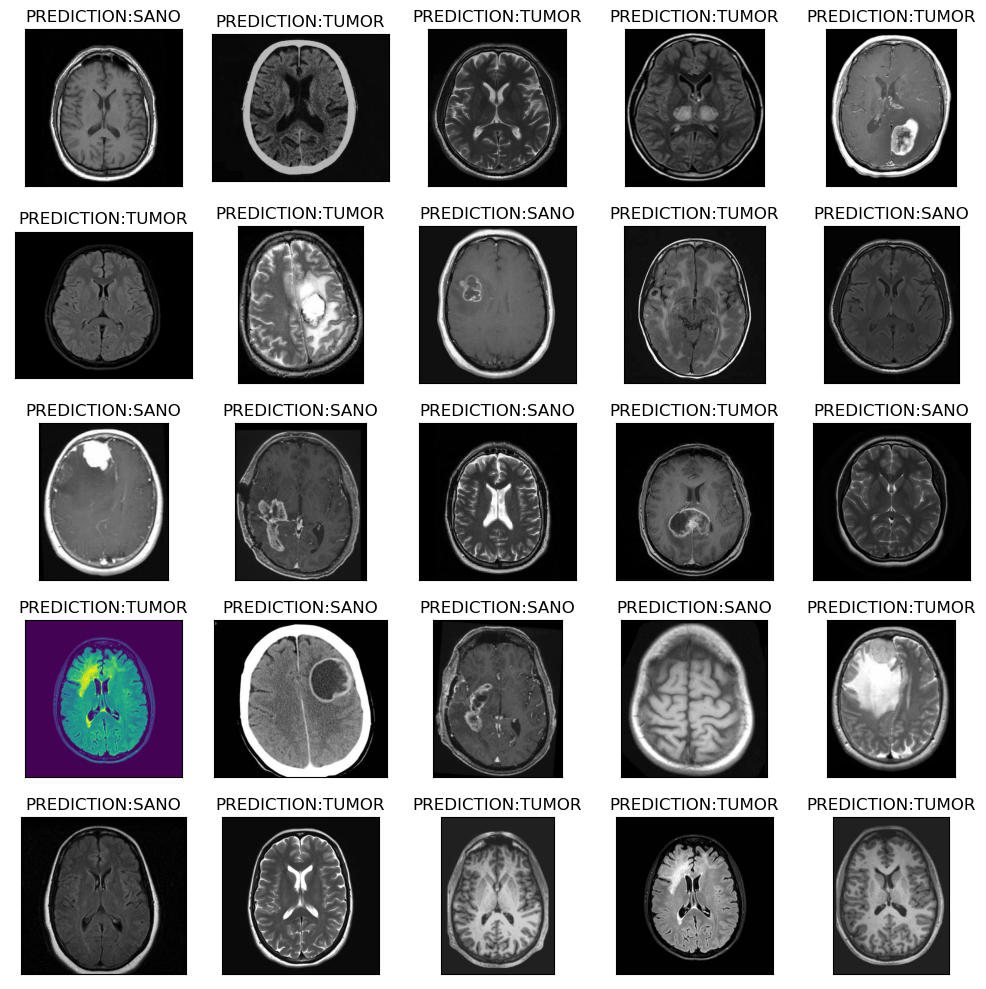

In [53]:

fig, axes = plt.subplots(nrows=5,
                         ncols=5,
                         figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_test["image"].loc[i]))
    ax.set_title(f"PREDICTION:{Last_Prediction[i]}")
plt.tight_layout()
plt.show()

In [23]:
def predict(filepath):
    IMG_SIZE = 200  # 50 in txt-based
    img_array = cv2.imread(filepath)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    arr = new_array.reshape (-1, IMG_SIZE, IMG_SIZE, 1)
    arreglo = Model.predict(arr)
    resultado = arreglo.argmax(axis=-1)

    return resultado

In [42]:
predict("./uploads/y0.jpg")

1/1 [==============================] - 0s 29ms/step


array([1, 1, 0])

In [48]:
Model.save("modeloBrain.h5")